# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [1]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.3.2


In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [23]:
AD = mmread("../data/mitoDNA/mitoMutOUT/top_100_passed_ad.mtx").tocsc()
DP = mmread("../data/mitoDNA/mitoMutOUT/top_100_passed_dp.mtx").tocsc()

## New implementation in v0.3.0

In [15]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [25]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=len(AD.getnnz(axis=1)), n_cell=len(AD.getnnz(axis=0)), n_donor=3, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [26]:
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

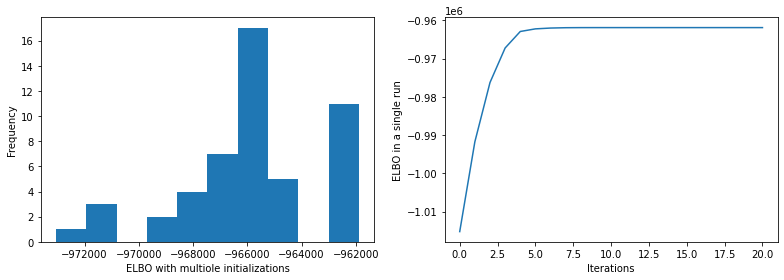

In [27]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiole initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [28]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.25355 0.00134]
 [0.13478 0.01760]
 [0.29248 0.18512]
 [0.09507 0.22850]
 [0.00196 0.01447]
 [0.24728 0.03999]
 [0.26382 0.05251]
 [0.25151 0.05018]
 [0.10639 0.17379]
 [0.13927 0.50380]
 [0.51619 0.24437]
 [0.13774 0.02693]
 [0.18709 0.58559]
 [0.11453 0.06865]
 [0.09955 0.15350]
 [0.44627 0.59841]
 [0.09804 0.14713]
 [0.27712 0.19973]
 [0.45010 0.57801]
 [0.10954 0.06863]
 [0.00408 0.00753]
 [0.00547 0.01399]
 [0.00521 0.01396]
 [0.36019 0.03213]
 [0.17220 0.27555]
 [0.04840 0.09488]
 [0.00642 0.01249]
 [0.01068 0.00437]
 [0.01754 0.00658]
 [0.02055 0.36241]
 [0.00379 0.01676]
 [0.34595 0.03597]
 [0.09033 0.13248]
 [0.34325 0.03804]
 [0.34533 0.03740]
 [0.02725 0.36809]
 [0.34389 0.03863]
 [0.00263 0.01402]
 [0.00096 0.00536]
 [0.00098 0.00515]
 [0.05931 0.36622]
 [0.00098 0.00490]
 [0.27745 0.13936]
 [0.00704 0.01204]
 [0.06311 0.08219]
 [0.00155 0.00595]
 [0.00488 0.00436]
 [0.00529 0.00768]
 [0.16841 0.42512]
 [0.03437 0.01145]
 [0.28235 0.21728]
 [0.00230 0.00476]
 [0.06292 0.

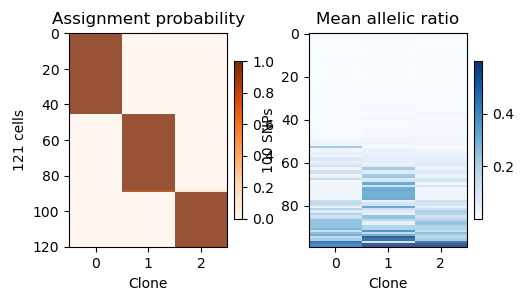

In [32]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()

plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()

In [21]:
np.sum(modelCA.predict_doublet(AD, DP)[0])

24.345370443081382

In [33]:
clone_id = np.argmax(modelCA.ID_prob, axis=1)
print(clone_id)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 2 2 2 1 2 2 2 2 2 2 2 1 2 1 2 1 1 2 1 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2]


### Choose the number of clones
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [11]:
n_initials = 50
n_clone_list = np.arange(2, 6)

_ELBO_mat = [] 
for k in n_clone_list:
    _elbo_temp = []
    for i in range(50):
        _modelCA = Vireo(n_var=9, n_cell=81, n_donor=k, n_GT=2,
                         fix_beta_sum=False, ASE_mode=True)
        _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
        _modelCA.fit(AD, DP, min_iter=20, verbose=False)
        _elbo_temp.append(_modelCA.ELBO_[-1])
    _ELBO_mat.append(_elbo_temp)

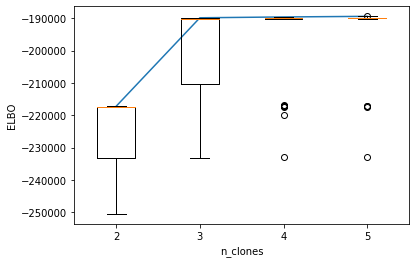

In [12]:
plt.plot([1, 2, 3, 4], np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(n_clone_list - 1, n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

### Old version

The old version seem more likely to end up at local optima in this data set.

In [13]:
from vireoSNP.utils.vireo_wrap_v02 import vireo_flock

In [14]:
# theta_prior = np.array([[0.01, 10], [0.4, 10], [5, 5]])
theta_prior = np.array([[0.1, 10], [5, 5]])
res = vireo_flock(AD, DP, n_donor=3, learn_GT=True,
                  n_extra_donor=0, ASE_mode=True,
                  theta_prior=theta_prior, learn_theta=True,
                  n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 3 clusters...
[vireo] donor size with searching extra 0 donors:
donor1	donor0	donor2
29	26	26
[vireo] warm-up: lower bound ranges [-416200.0, -416200.0, -354289.9]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 22 iterations; lower bound -354289.9
[vireo] beta parameters for binomial rate:
[[[541.10 32126.10 1416.10 3379.10 451.10 126.10 3283.10 800.10 904.10]
  [231291.00 4129625.00 165112.00 329376.00 262057.98 29511.01 88940.00
   98072.00 46164.00]]

 [[5.00 5.00 5.00 5.00 48689.00 7392.00 5.00 5.00 5.00]
  [5.00 5.00 5.00 5.00 79400.02 55905.99 5.00 5.00 5.00]]]


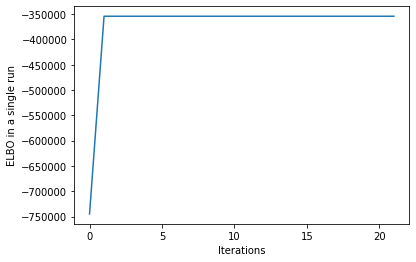

In [15]:
plt.plot(res['LB_list'])
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")
plt.show()

In [16]:
## If ASE_mode is True
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)

_new_shape = (AF_mean.shape[1], 1, AF_mean.shape[0])
AF_SNPs = np.sum(res['GT_prob'] * AF_mean.transpose().reshape(_new_shape), axis=2)

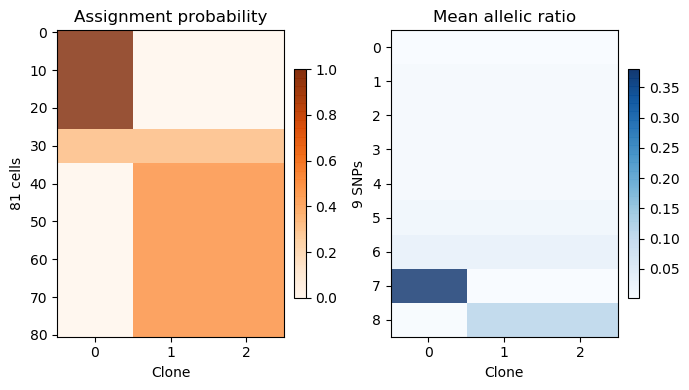

In [17]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(res['ID_prob'], cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.xlabel("Clone")
plt.xticks([0, 1, 2])

plt.subplot(1, 2, 2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.xticks([0, 1, 2])
plt.xlim(-0.5, 2.5)

plt.tight_layout()
plt.show()